<a href="https://colab.research.google.com/github/saheedniyi02/CIFAR-10-CNN/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 36.1 MB/s 


In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
import keras
import numpy as np
import pydot
import graphviz
import tensorflow as tf
import keras_tuner as kt
import pandas as pd
from IPython.display import SVG
from keras.datasets import cifar10
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPool2D, Flatten, Dropout, Dense,Input, Conv2D ,BatchNormalization
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import MobileNet
from sklearn.model_selection import train_test_split

**LOAD THE DATA**

In [ ]:
(train,target),(test,y_test)=cifar10.load_data()

170508288/170498071 [==============================] - 13s 0us/step


In [ ]:
X,val,y,y_val=train_test_split(train,target,test_size=0.05,random_state=0)

In [ ]:
print(f"X Shape: {X.shape},target shape: {y.shape}")
print(f"val Shape: {val.shape},target shape: {y_val.shape}")
print(f"Test Shape: {test.shape},y_test shape: {y_test.shape}")

X Shape: (47500, 32, 32, 3),target shape: (47500, 1)
val Shape: (2500, 32, 32, 3),target shape: (2500, 1)
Test Shape: (10000, 32, 32, 3),y_test shape: (10000, 1)


**Print figure with 10 random images from the 0 dataset.**

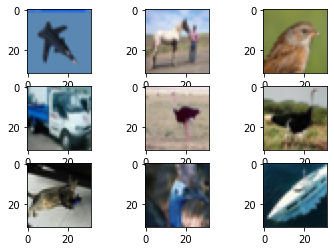

In [ ]:
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X[i])
# show the figure
plt.show()

In [ ]:
value_count=pd.DataFrame({"y":y[:,0]})["y"].value_counts()
print(value_count)

4    4779
8    4767
2    4764
7    4760
6    4756
9    4752
1    4748
0    4742
5    4718
3    4714
Name: y, dtype: int64


**One Hot Encoding the target and test class**

In [ ]:
input_shape=(32,32,3)

In [ ]:
y_one_hot = to_categorical(y ,dtype="uint8")
y_val_one_hot = to_categorical(y_val,dtype="uint8")
y_test_one_hot = to_categorical(y_test ,dtype="uint8")

In [ ]:
X= X.astype("float32")
val = val.astype("float32")
test= test.astype("float32")
# normalize to range 0-1
X_normalized= X / 255.0
val_normalized = val / 255.0
test_normalized = test/255.0

**Parameter tuning**

In [ ]:
def build_model(hp):


  units1=hp.Choice('units', values=[256,512,1024])
  dropout1=hp.Choice('rate', [0.125,0.25,0.5,0.75])
  filter1=hp.Choice('filters', values=[32,64,128,256])
  learning_rate=hp.Choice('learning_rate', values=[0.01, 0.05, 0.001,0.005])
  model =Sequential([
                     Conv2D(filters=16, kernel_size=(2,2),activation='relu', input_shape=(32,32,3)),
                     MaxPool2D(pool_size=(2,2), strides=(2,2)),
                     BatchNormalization(),
                     Conv2D(filters=32, kernel_size=(2,2), strides=1, activation='relu'),
                     MaxPool2D(pool_size=(2,2), strides=1),
                     BatchNormalization(),
                     Conv2D(filters=64, kernel_size=(2,2), strides=1, activation='relu'),
                     MaxPool2D(pool_size=(2,2),strides=1),
                     BatchNormalization(),
                     Conv2D(filters=128, kernel_size=(2,2), strides=1, activation='relu'),
                     MaxPool2D(pool_size=(2,2),strides=1),
                     BatchNormalization(),
                     Conv2D(filters=filter1, kernel_size=(2,2), strides=1, activation='relu'),
                     BatchNormalization(),
                     MaxPool2D(pool_size=(2,2), strides=(2,2)),
                     Flatten(),
                     Dense(512, activation='relu'),
                     Dense(units1, activation='relu'),
                     Dropout(dropout1),
                     Dense(10, activation='softmax')
                     ])

 
  model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=learning_rate, momentum=0.9), metrics=['accuracy'])
  return model

In [ ]:
tuner = kt.RandomSearch(build_model,objective='val_accuracy',max_trials=10,seed=1)

In [ ]:
tuner.search(X_normalized, y_one_hot, epochs=20, validation_data=(val_normalized, y_val_one_hot))

Trial 1 Complete [00h 05m 54s]
val_accuracy: 0.676800012588501

Best val_accuracy So Far: 0.676800012588501
Total elapsed time: 00h 05m 54s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
1024              |256               |units
0.125             |0.125             |rate
128               |64                |filters
0.05              |0.05              |learning_rate

Epoch 1/20
1485/1485 [==============================] - 19s 12ms/step - loss: 1.6684 - accuracy: 0.4067 - val_loss: 2.1982 - val_accuracy: 0.3092
Epoch 2/20
1485/1485 [==============================] - 18s 12ms/step - loss: 1.3165 - accuracy: 0.5446 - val_loss: 1.4089 - val_accuracy: 0.5264
Epoch 3/20
1485/1485 [==============================] - 18s 12ms/step - loss: 1.1721 - accuracy: 0.6007 - val_loss: 1.2810 - val_accuracy: 0.5664
Epoch 4/20
1485/1485 [==============================] - 18s 12ms/step - loss: 1.1081 - accuracy: 0.6265 - val_loss: 1.1515 - val_accuracy: 0.6328
Epoch 5/20

KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 256
rate: 0.125
filters: 64
learning_rate: 0.05
Score: 0.676800012588501


**Model**

In [ ]:
best_learning_rate=0.005
best_filter=128
best_units=256
best_dropout_rate=0.25

model =Sequential([  Conv2D(filters=16, kernel_size=(2,2),activation='relu', input_shape=(32,32,3)),
                     MaxPool2D(pool_size=(2,2), strides=(2,2)),
                     BatchNormalization(),
                     Conv2D(filters=32, kernel_size=(2,2), strides=1, activation='relu'),
                     MaxPool2D(pool_size=(2,2), strides=1),
                     BatchNormalization(),
                     Conv2D(filters=64, kernel_size=(2,2), strides=1, activation='relu'),
                     MaxPool2D(pool_size=(2,2),strides=1),
                     BatchNormalization(),
                     Conv2D(filters=128, kernel_size=(2,2), strides=1, activation='relu'),
                     MaxPool2D(pool_size=(2,2),strides=1),
                     BatchNormalization(),
                     Conv2D(filters=best_filter, kernel_size=(2,2), strides=1, activation='relu'),
                     BatchNormalization(),
                     MaxPool2D(pool_size=(2,2), strides=(2,2)),
                     Flatten(),
                     Dense(512, activation='relu'),
                     Dense(best_units, activation='relu'),
                     Dropout(best_dropout_rate),
                     Dense(10, activation='softmax')
                     ])

In [ ]:
auc=tf.keras.metrics.AUC()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=best_learning_rate, momentum=0.9), metrics=['accuracy',auc])

In [ ]:
model_history=model.fit(X_normalized, y_one_hot, epochs=20, batch_size=64, validation_data=(val_normalized, y_val_one_hot), verbose=1)

Epoch 1/20
743/743 [==============================] - 19s 8ms/step - loss: 1.4299 - accuracy: 0.4914 - auc: 0.8812 - val_loss: 1.4955 - val_accuracy: 0.4976 - val_auc: 0.8784
Epoch 2/20
743/743 [==============================] - 5s 7ms/step - loss: 1.0558 - accuracy: 0.6283 - auc: 0.9364 - val_loss: 1.2548 - val_accuracy: 0.5584 - val_auc: 0.9105
Epoch 3/20
743/743 [==============================] - 5s 7ms/step - loss: 0.8857 - accuracy: 0.6879 - auc: 0.9550 - val_loss: 0.9125 - val_accuracy: 0.6884 - val_auc: 0.9521
Epoch 4/20
743/743 [==============================] - 5s 7ms/step - loss: 0.7682 - accuracy: 0.7309 - auc: 0.9658 - val_loss: 0.9881 - val_accuracy: 0.6524 - val_auc: 0.9450
Epoch 5/20
743/743 [==============================] - 5s 7ms/step - loss: 0.6696 - accuracy: 0.7648 - auc: 0.9737 - val_loss: 0.9841 - val_accuracy: 0.6652 - val_auc: 0.9450
Epoch 6/20
743/743 [==============================] - 5s 7ms/step - loss: 0.5848 - accuracy: 0.7929 - auc: 0.9796 - val_loss: 0.8

In [ ]:
model.summary()

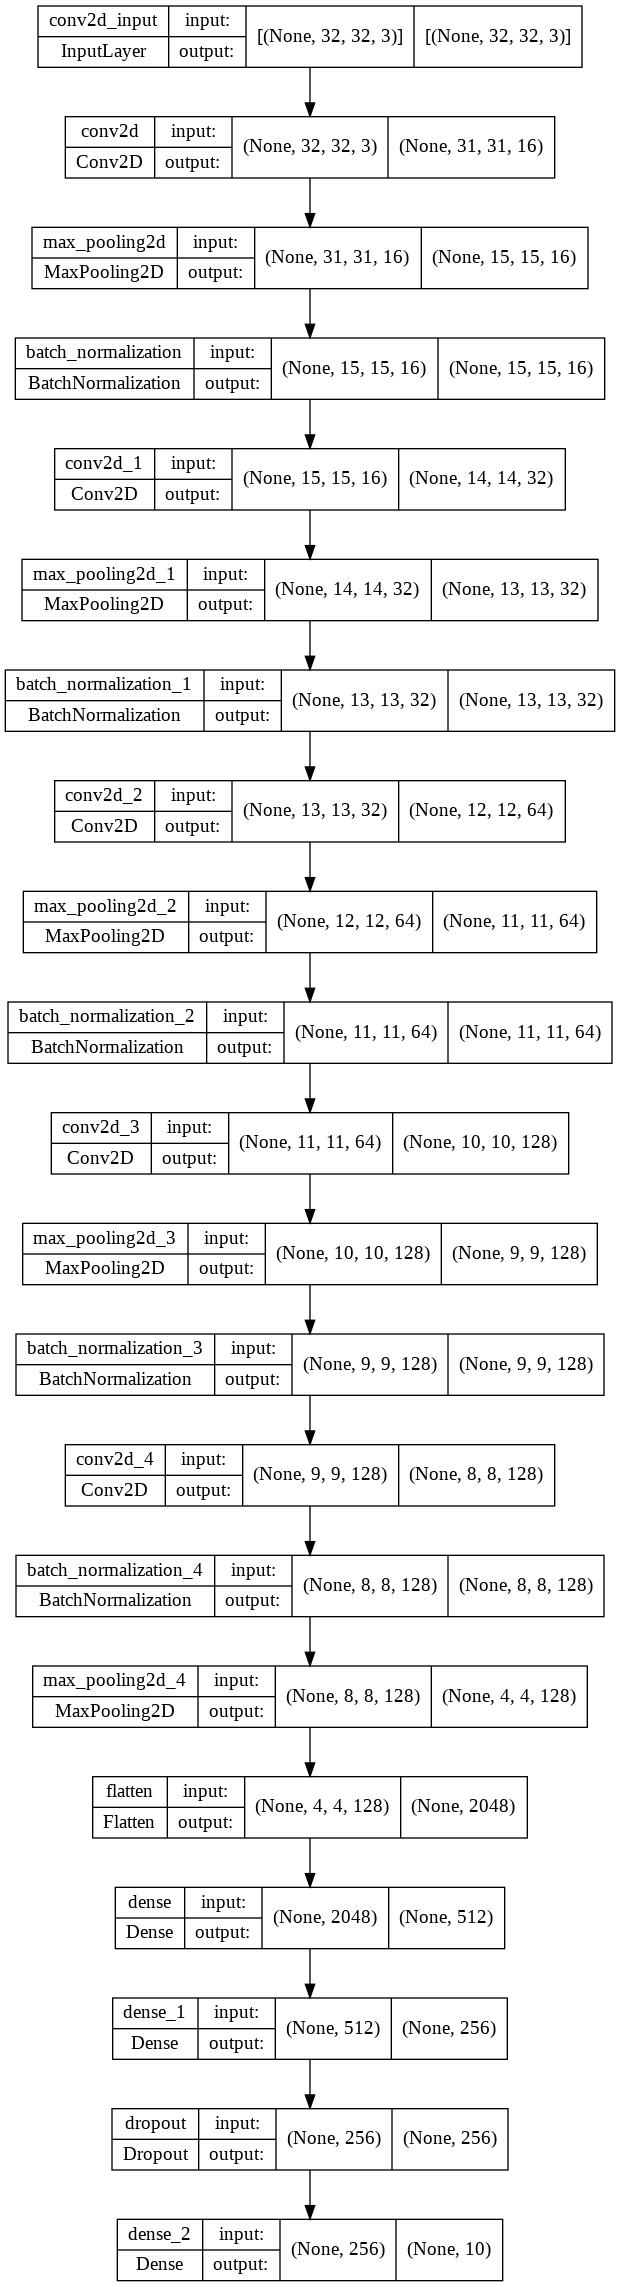

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

**PRETRAINED MODEL**

In [ ]:
mobilenet=MobileNet(include_top=False,input_shape=(32,32,3))

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
pretrained_model=Sequential()
pretrained_model.add(mobilenet)
pretrained_model.add(Flatten())
pretrained_model.add(Dense(512,activation="relu"))
pretrained_model.add(Dense(10,activation="softmax"))

In [ ]:
pretrained_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 10)                5130      
                                                                 
Total params: 3,758,794
Trainable params: 3,736,906
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
# Compile model 
lrate = 0.01  
sgd = SGD(learning_rate=lrate, momentum=0.9) 
pretrained_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
pretrained_history=pretrained_model.fit(X_normalized, y_one_hot, epochs=20, batch_size=64, validation_data=(val_normalized, y_val_one_hot), verbose=1)

Epoch 1/20
743/743 [==============================] - 14s 16ms/step - loss: 1.3554 - accuracy: 0.5292 - val_loss: 1.0963 - val_accuracy: 0.6128
Epoch 2/20
743/743 [==============================] - 10s 14ms/step - loss: 0.8931 - accuracy: 0.6916 - val_loss: 0.8587 - val_accuracy: 0.6956
Epoch 3/20
743/743 [==============================] - 10s 14ms/step - loss: 0.7300 - accuracy: 0.7487 - val_loss: 0.8084 - val_accuracy: 0.7236
Epoch 4/20
743/743 [==============================] - 11s 14ms/step - loss: 0.6256 - accuracy: 0.7848 - val_loss: 0.7750 - val_accuracy: 0.7248
Epoch 5/20
743/743 [==============================] - 11s 14ms/step - loss: 0.5481 - accuracy: 0.8109 - val_loss: 0.7005 - val_accuracy: 0.7624
Epoch 6/20
743/743 [==============================] - 11s 14ms/step - loss: 0.4921 - accuracy: 0.8319 - val_loss: 0.6673 - val_accuracy: 0.7764
Epoch 7/20
743/743 [==============================] - 11s 14ms/step - loss: 0.4338 - accuracy: 0.8503 - val_loss: 0.7012 - val_accuracy:

**comparison**

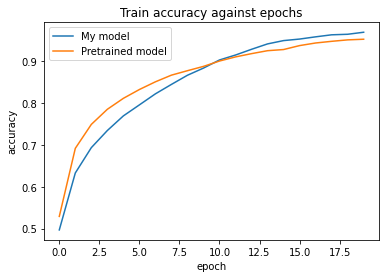

In [ ]:
#comparison for train accuracy history
plt.plot(model_history.history['accuracy'])
plt.plot(pretrained_history.history['accuracy'])
plt.title('Train accuracy against epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['My model', 'Pretrained model'], loc='upper left')
plt.show()

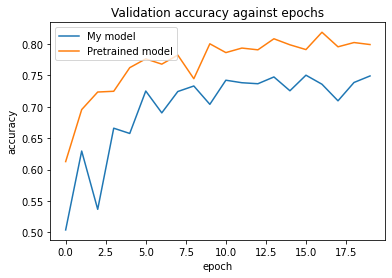

In [ ]:
#comparison for validation accuracy history
plt.plot(model_history.history['val_accuracy'])
plt.plot(pretrained_history.history['val_accuracy'])
plt.title('Validation accuracy against epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['My model', 'Pretrained model'], loc='upper left')
plt.show()

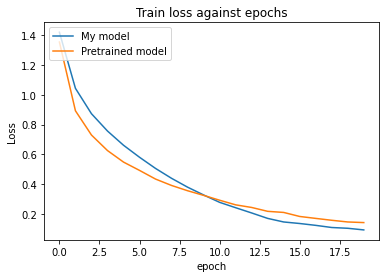

In [ ]:
#comparison for train loss history
plt.plot(model_history.history['loss'])
plt.plot(pretrained_history.history['loss'])
plt.title('Train loss against epochs')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['My model', 'Pretrained model'], loc='upper left')
plt.show()

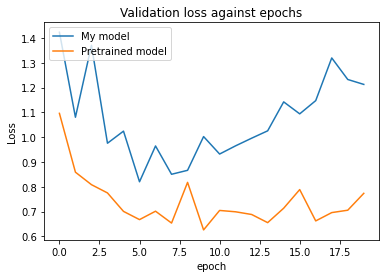

In [ ]:
#comparison for validation loss history
plt.plot(model_history.history['val_loss'])
plt.plot(pretrained_history.history['val_loss'])
plt.title('Validation loss against epochs')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['My model', 'Pretrained model'], loc='upper left')
plt.show()

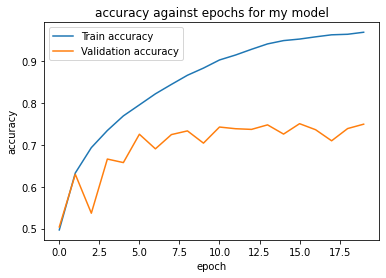

In [ ]:
#comparison for train accuracy history
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('accuracy against epochs for my model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

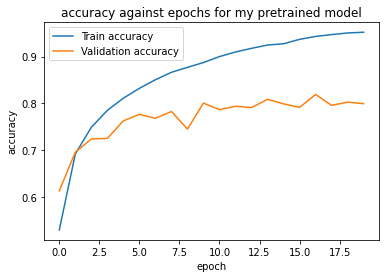

In [ ]:
#comparison for train accuracy history
plt.plot(pretrained_history.history['accuracy'])
plt.plot(pretrained_history.history['val_accuracy'])
plt.title('accuracy against epochs for my pretrained model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

In [ ]:
model_loss,model_accuracy=model.evaluate(test_normalized, y_test_one_hot)
print(f"My model accuracy is {model_accuracy*100}%")
print(f"My model loss is {model_loss}")

313/313 [==============================] - 2s 5ms/step - loss: 1.1748 - accuracy: 0.7500
My model accuracy is 75.0%
My model loss is 1.174763798713684


In [ ]:
pretrained_loss,pretrained_accuracy=pretrained_model.evaluate(test_normalized,y_test_one_hot)
print(f"Pretrained model accuracy is {pretrained_accuracy*100}%")
print(f"Pretrained model loss is {pretrained_loss}")

313/313 [==============================] - 2s 7ms/step - loss: 0.8438 - accuracy: 0.7861
Pretrained model accuracy is 78.60999703407288%
Pretrained model loss is 0.8437989950180054
